In [1]:
from bisect import bisect_left
from collections import Counter, OrderedDict
from itertools import accumulate
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
LANGUAGE = 'Python'
DIR_OUT = 'out/' + LANGUAGE
DPI = 144
COLUMNS = (
    ('DevType', True),
    ('FormalEducation', False),
    ('UndergradMajor', False),
    ('Age', False),
    ('LanguageWorkedWith', True),
    ('LanguageDesireNextYear', True),
    ('DatabaseWorkedWith', True),
    ('DatabaseDesireNextYear', True),
    ('PlatformWorkedWith', True),
    ('PlatformDesireNextYear', True),
    ('FrameworkWorkedWith', True),
    ('FrameworkDesireNextYear', True),
    ('IDE', True),
    ('OperatingSystem', False),
    ('CommunicationTools', True),
    ('NumberMonitors', False),
    ('Methodology', True),
    ('VersionControl', True),
)

In [3]:
data_raw = pd.read_csv('data/survey_results_public.csv', low_memory=False)

In [4]:
data_raw.describe()

,Respondent,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,...,JobEmailPriorities6,JobEmailPriorities7,ConvertedSalary,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7
count,98855.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,...,46213.00000,46213.000000,4.770200e+04,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000
mean,50822.971635,6.397089,6.673524,5.906875,4.065791,3.953243,4.407196,5.673181,4.225200,7.640009,...,4.97425,4.836388,9.578086e+04,2.726880,3.805784,3.340945,3.782470,4.383604,5.138809,4.821459
std,29321.650410,2.788428,2.531202,2.642734,2.541196,2.520499,2.502069,2.923998,2.507411,2.407457,...,1.86063,1.659844,2.023482e+05,1.881078,1.821323,1.673485,1.844864,1.931746,1.853249,1.874895
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,25443.500000,4.000000,5.000000,4.000000,2.000000,2.000000,2.000000,3.000000,2.000000,6.000000,...,4.00000,4.000000,2.384400e+04,1.000000,2.000000,2.000000,2.000000,3.000000,4.000000,3.000000
50%,50823.000000,7.000000,7.000000,6.000000,4.000000,3.000000,4.000000,6.000000,4.000000,8.000000,...,5.00000,5.000000,5.507500e+04,2.000000,4.000000,3.000000,4.000000,5.000000,6.000000,5.000000
75%,76219.500000,9.000000,9.000000,8.000000,6.000000,6.000000,6.000000,8.000000,6.000000,10.000000,...,7.00000,6.000000,9.300000e+04,4.000000,5.000000,5.000000,5.000000,6.000000,7.000000,7.000000
max,101592.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,7.00000,7.000000,2.000000e+06,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [5]:
data = data_raw[data_raw['LanguageWorkedWith'].str.contains(LANGUAGE).isin([True])]

In [6]:
len(data_raw), len(data), '{:.1f}%'.format(len(data) / len(data_raw) * 100)

(98855, 30359, '30.7%')

In [7]:
def calc_summary(series, sep=';', labeled_ratio=0.9):
    '''Generate stats summary data for a series.'''
    count_dict = Counter(
        ide for ides in series.str.split(sep)
            if isinstance(ides, list)
            for ide in ides
    )
    count = count_dict.most_common()

    labeled_total_count = sum(x[1] for x in count) * labeled_ratio
    accumulated_counts = list(accumulate(x[1] for x in count))
    index = bisect_left(accumulated_counts, labeled_total_count)
    
    count_tops, count_others = count[:index], count[index:]
    count_tops.append(('others', sum(x[1] for x in count_others)))
    
    return count_tops

In [8]:
def prepare_pie(count_summary):
    '''Prepare a pie chart with a list of pairs of label and count.'''
    labels, values = zip(*count_summary)
    options = {
        'counterclock': False,
        'startangle': 90,
        'autopct': '%.0f%%',
    }

    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, **options)

    # Set aspect ratio 1:1.
    ax.axis('equal')

In [9]:
def prepare_bar_horizontal(count_summary, total, ratio_margin=None):
    '''Prepare a horizontal bar chart with a list of pairs of label and count.'''
    labels, values = zip(*count_summary)
    indices = np.arange(len(labels))

    fig, ax = plt.subplots()
    ax.barh(indices, values)

    # Set settings related to y-axis.
    ax.set_yticks(indices)
    ax.set_yticklabels(labels)

    # Sort rows by the original order.
    ax.invert_yaxis()
    
    # Set max value to the total count.
    plt.xlim(0, total)
    
    # Add percentage labels.
    if not ratio_margin:
        ratio_margin = total / 50
    for i, v in zip(indices, values):
        ax.text(min(total, v) + ratio_margin, i + 0.2, '{:2.0f}%'.format(v / total * 100))

In [10]:
def save_and_show(path):
    plt.savefig(path, dpi=DPI, bbox_inches='tight')
    plt.show()

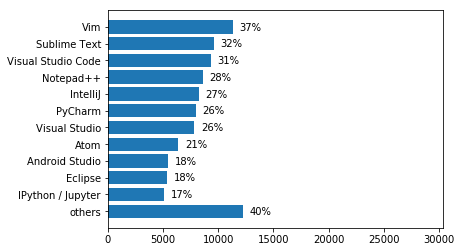

In [11]:
data_ide = data['IDE']
prepare_bar_horizontal(calc_summary(data_ide), len(data_ide))
plt.show()

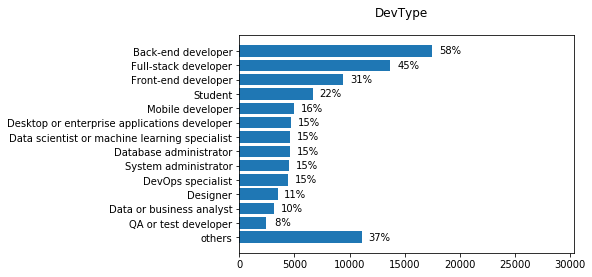

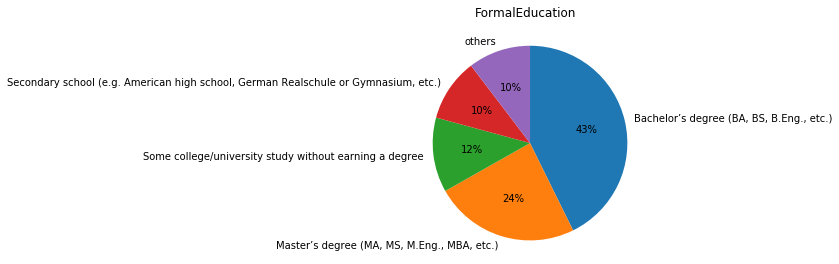

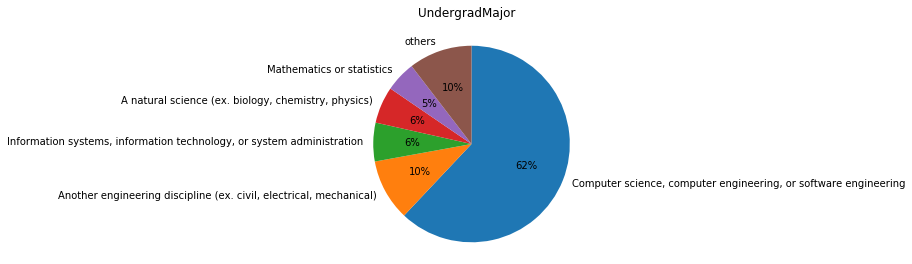

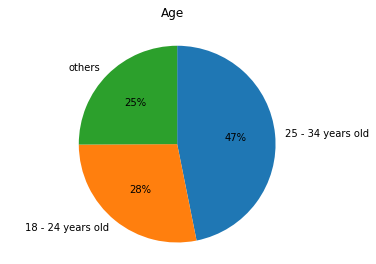

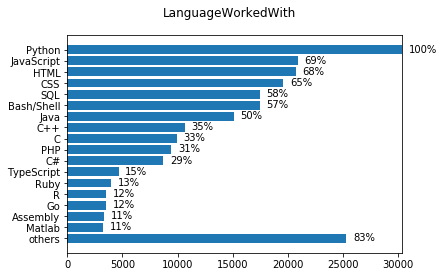

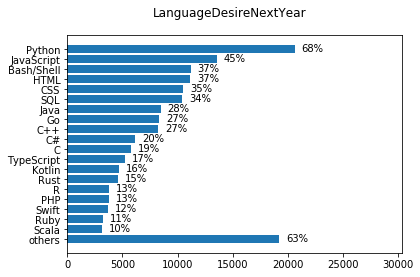

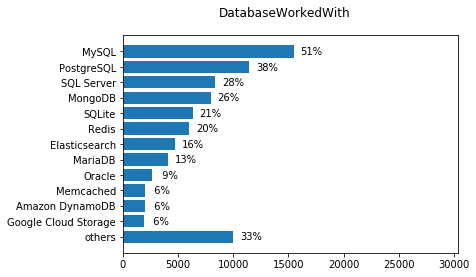

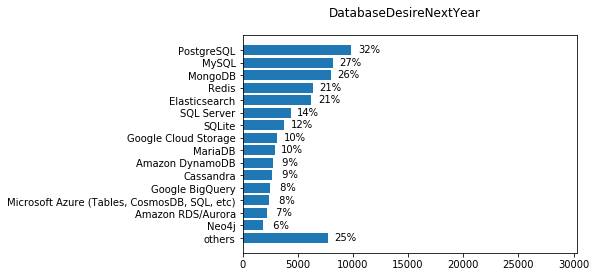

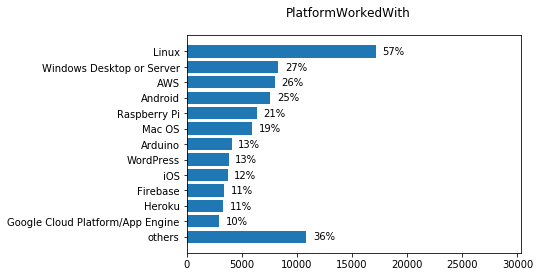

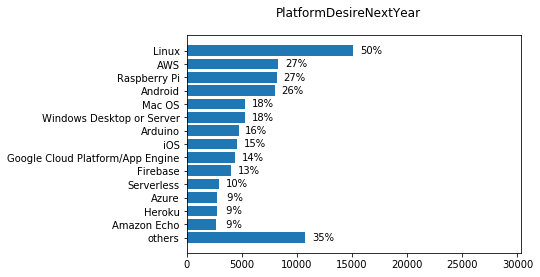

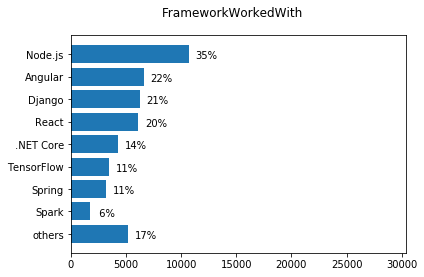

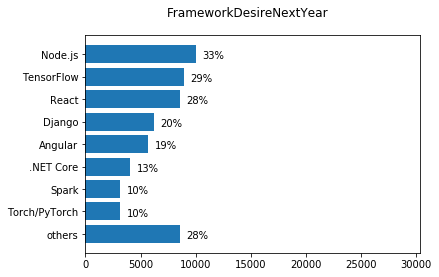

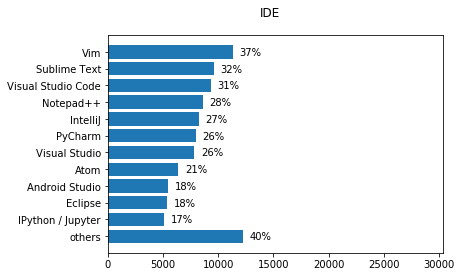

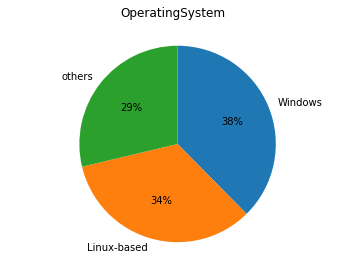

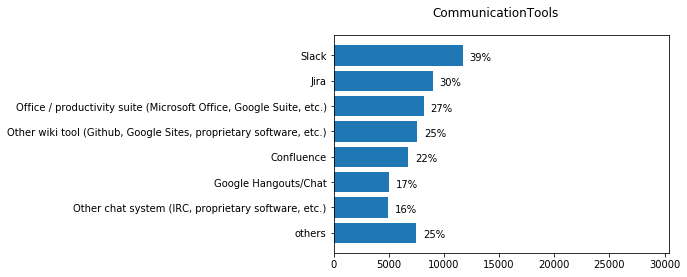

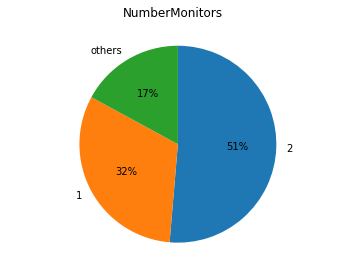

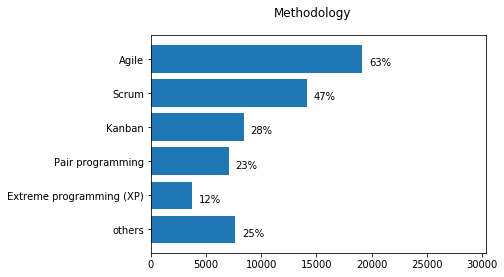

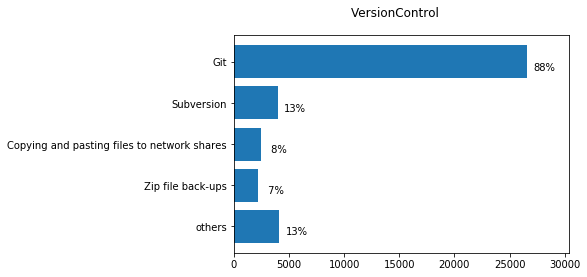

In [12]:
data_count = len(data)
dir_out = Path(DIR_OUT)
if not dir_out.is_dir():
    dir_out.mkdir()
for column, is_multiple in COLUMNS:
    if is_multiple:
        prepare_bar_horizontal(calc_summary(data[column]), data_count)
    else:
        prepare_pie(calc_summary(data[column]))

    plt.suptitle(column)
    save_and_show(dir_out / 'chart-{}.png'.format(column))